# 5. Calibration of double ended measurement with OLS

A double ended calibration is performed with ordinary least squares. Over all timesteps simultaneous. $\gamma$ and $\alpha$ remain constant, while $C$ varies over time. The weights are considered equal here and no variance or confidence interval is calculated.

In [1]:
import os

from dtscalibration import read_silixa_files
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
try:
    wd = os.path.dirname(os.path.realpath(__file__))
except:
    wd = os.getcwd()

filepath = os.path.join(wd, '..', '..', 'tests', 'data', 'single_ended')
timezone_netcdf = 'UTC'
timezone_input_files = 'Europe/Amsterdam'
file_ext = '*.xml'

ds = read_silixa_files(
    directory=filepath,
    timezone_netcdf=timezone_netcdf,
    timezone_input_files=timezone_input_files,
    file_ext=file_ext)

ds100 = ds.sel(x=slice(-30, 101))  # only calibrate parts of the fiber
sections = {
            'probe1Temperature':    [slice(20, 25.5)],  # warm bath
            'probe2Temperature':    [slice(5.5, 15.5)],  # cold bath
#             'referenceTemperature': [slice(-24., -4)]  # The internal coil is not so uniform
            }

3 files were found, each representing a single timestep
4 recorded vars were found: LAF, ST, AST, TMP
Recorded at 1461 points along the cable
The measurement is single ended


In [3]:
print(ds100.calibration_single_ended.__doc__)



        Parameters
        ----------
        sections : dict, optional
        st_label : str
            Label of the forward stokes measurement
        ast_label : str
            Label of the anti-Stoke measurement
        st_var : float, optional
            The variance of the measurement noise of the Stokes signals in the forward
            direction Required if method is wls.
        ast_var : float, optional
            The variance of the measurement noise of the anti-Stokes signals in the forward
            direction. Required if method is wls.
        store_c : str
            Label of where to store C
        store_gamma : str
            Label of where to store gamma
        store_dalpha : str
            Label of where to store dalpha; the spatial derivative  of alpha.
        store_alpha : str
            Label of where to store alpha; The integrated differential attenuation.
            alpha(x=0) = 0
        store_tmpf : str
            Label of where to store the

In [4]:
st_label = 'ST'
ast_label = 'AST'
ds100.calibration_single_ended(sections=sections,
                               st_label=st_label,
                               ast_label=ast_label,
                               method='ols')

 
LSQR            Least-squares solution of  Ax = b
The matrix A has      366 rows  and        5 cols
damp = 0.00000000000000e+00   calc_var =        1
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       10
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  4.82000e+02   2.948e+01  2.948e+01    1.0e+00  1.0e+01
     1  4.82000e+02   6.004e-01  6.004e-01    1.4e-01  1.4e-02   3.1e+02  1.0e+00
     2  4.81999e+02   1.868e-02  1.868e-02    4.4e-03  3.4e-02   3.1e+02  7.1e+01
     3  4.81999e+02   6.248e-03  6.248e-03    1.5e-03  2.7e-05   3.1e+02  7.6e+01
     4  4.81999e+02   6.248e-03  6.248e-03    1.5e-03  1.2e-08   4.4e+02  1.1e+02
     5  4.81877e+02   6.248e-03  6.248e-03    1.5e-03  1.6e-08   4.4e+02  8.6e+05
     6  4.81877e+02   6.248e-03  6.248e-03    1.5e-03  2.3e-08   4.7e+02  9.2e+05
     7  4.81877e+02   6.248e-03  6.248e-03    1.5e-03  6.8e-09   5.3e+02  1.1e+06
 
LSQR finished
The least-sq

Lets compare our calibrated values with the device calibration

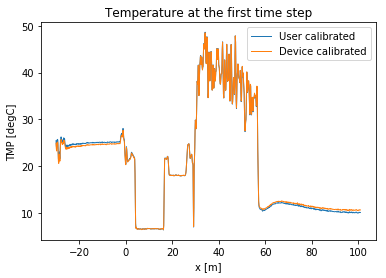

In [5]:
ds1 = ds100.isel(time=0)  # take only the first timestep

ds1.TMPF.plot(linewidth=1, label='User calibrated')  # plot the temperature calibrated by us
ds1.TMP.plot(linewidth=1, label='Device calibrated')  # plot the temperature calibrated by the device
plt.title('Temperature at the first time step')
plt.legend()